In [26]:
#IBM Data Science Applied Capstone Project Week 4

# Analyzing Venues and Real Estate Prices of Delhi

## 1. Introduction

### 1.1. Background

Delhi, officially the National Capital Territory of Delhi (NCT), is a city and a union territory of India containing New Delhi, the capital of India. The NCT covers an area of **1,484 square kilometers (573 sq mi)**. According to the 2011 census, Delhi's city proper population was over **16 million**, the second-highest in India. The city is divided into **272 wards**. As a resident of this city, I decided to use this for my project.

As evident from the figures, Delhi is a city with a huge population and a high population density. Being such a crowded and huge city, it must be advantageous for shop keepers, local businesses and/or investors to accurately be able to determine the locality suitable for their type of business based on several factors such as: 
* level of the population: higher the better
* price of real estate: lower prices will be preferred

At the same time, they may want to choose the district according to the density of the social places.  However, it is difficult to obtain information that will guide investors in this direction, nowadays. 
When we consider all these problems, we can create a map and information chart where the real estate index is placed on Delhi and each ward is clustered according to the venue density. Another idea is to check for correlations between the real estate prices and the population and the venue density of the wards.

### 1.2. Data Description
1. A GEOJSON file containing all the Delhi wards is used and it can be found here. The Ward Number and Ward Name features were selected.
2. Real estate prices were manually added from here. There were a lot of localities for which there was no real estate price data available. It was either due to that locality being an industrial zone or it not having and residential land or there being no residential land open to the public such as government-owned properties or army cantonments. I removed those localities and continued with only those localities for which we have the real estate price data.
3. The population data was scraped from a table found here.
4. Bing API was used to geocode all the localities.
5. Foursquare API was used to get the most common venues of given localities.

# Collecting and Processing Data

In [174]:
import json #to read the json file containing delhi spatial data
import pandas as pd 

import os #for retrieving the API keys

#libraries to geocodem, map and visualize spatial data
from geopy.geocoders import Nominatim
from geopy.geocoders import Bing
from geopy.extra.rate_limiter import RateLimiter 
import folium

import requests #for making api calls

from IPython.display import Image #to visualize the images of maps constructed
PATH = "D:/IBM Data Science/Coursera_Capstone/Delhi Analysis/"

from bs4 import BeautifulSoup #to scrape web data

Loading the geojson file containing the spatial data for the wards of Delhi. Delhi is divided into 272 wards.

In [213]:
with open('Delhi_Wards - Copy.geojson') as json_data:
    delhi_geojson = json.load(json_data)

You can view the json file here: https://github.com/datameet/Municipal_Spatial_Data/blob/master/Delhi/Delhi_Wards.geojson?short_path=18d52b8 <br>
I have commented the below cell as the file is very big.

In [52]:
#delhi_geojson

Taking a look at the structure of one of the wards.

In [214]:
delhi_temp = delhi_geojson['features']
delhi_temp[0]

{'type': 'Feature',
 'properties': {'Ward_Name': 'CHANDNI CHOWK', 'Ward_No': '80'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[77.24385854400003, 28.661652037000067],
    [77.24402922400003, 28.66151803500003],
    [77.24412803800004, 28.660911086000056],
    [77.24467601100008, 28.660895321000055],
    [77.24755960300007, 28.658924683000066],
    [77.24827825500006, 28.658294070000068],
    [77.24848486700006, 28.656465274000027],
    [77.24914063800003, 28.654825636000055],
    [77.25082048700006, 28.652137520000053],
    [77.25112591400006, 28.651301904000036],
    [77.25135049300007, 28.651120590000062],
    [77.24561924200003, 28.650891976000025],
    [77.24386752700008, 28.65031649900004],
    [77.24035511400007, 28.650284966000072],
    [77.23906154000008, 28.649819851000075],
    [77.23654625700004, 28.65331210100004],
    [77.23648337500003, 28.65381661500004],
    [77.23686066800008, 28.65773439900005],
    [77.23675287000003, 28.65882220800006],
    [77.23520776800

#### Creating a dataframe to contain the ward number and its name.

In [215]:
delhi_neighbourhoods = pd.DataFrame(columns=['Ward Number', 'Neighbourhoods', 'Latitude', 'Longitude'])

#### Appending the Neighbourhood data into the dataframe

In [216]:
for data in delhi_temp:
    hood = data['properties']['Ward_Name']
    wno = data['properties']['Ward_No']
    temp = data['geometry']['coordinates'][0]
    avg = [float(sum(col))/len(col) for col in zip(*temp)]
    delhi_neighbourhoods = delhi_neighbourhoods.append({'Ward Number': wno, 
                                                        'Neighbourhoods': hood, 
                                                        'Latitude': avg[1], 
                                                        'Longitude':avg[0]}, ignore_index=True)

In [217]:
delhi_neighbourhoods.tail(10)

,Ward Number,Neighbourhoods,Latitude,Longitude
53,49,ROHINI NORTH,28.738912,77.134561
54,99,MOTI NAGAR,28.669234,77.145449
55,155,LAJPAT NAGAR,28.573543,77.248105
56,163,SAFDARJANG ENCLAVE,28.558222,77.198570
57,164,HAUZ KHAS,28.556218,77.208522
58,106,TAGORE GARDEN,28.644996,77.104856
59,224,PANDAV NAGAR,28.622639,77.276422
60,205,ZAKIR NAGAR,28.571116,77.279686
61,113,MAHAVIR NAGAR,28.634869,77.077271
62,153,DARYAGANJ,28.630110,77.248757


In [33]:
#Creating a dataframe containing the string ', Delhi, India' after the neighbourhood name to accurately geocode the neighbourhood
addresses = delhi_neighbourhoods['Neighbourhoods']+', Delhi, India'
addresses.head()

0    DELHI CANTT CHARGE 1, Delhi, India
1    DELHI CANTT CHARGE 2, Delhi, India
2    DELHI CANTT CHARGE 4, Delhi, India
3    DELHI CANTT CHARGE 5, Delhi, India
4    DELHI CANTT CHARGE 6, Delhi, India
Name: Neighbourhoods, dtype: object

#### Geocoding the Neighbourhoods using the Bing API
I find the Bing API to be more powerful and accurate than Nominatim, hence, have used it instead.

In [53]:
key = os.environ.get('BING_KEY')
#print(key)

In [35]:
locator = Bing(api_key=key, user_agent="delhi_hoods")
geocode = RateLimiter(locator.geocode, min_delay_seconds=0.1)
delhi_neighbourhoods['location'] = addresses.apply(geocode)
delhi_neighbourhoods['point'] = delhi_neighbourhoods['location'].apply(lambda loc: tuple(loc.point) if loc else None)
delhi_neighbourhoods.head(10)

,Ward Number,Neighbourhoods,location,point
0,CANT_1,DELHI CANTT CHARGE 1,"(1, Delhi, Delhi 110010, India, (28.60562, 77....","(28.60562, 77.11822, 0.0)"
1,CANT_2,DELHI CANTT CHARGE 2,"(2, Delhi, Delhi 110010, India, (28.60544, 77....","(28.60544, 77.11829, 0.0)"
2,CANT_4,DELHI CANTT CHARGE 4,"(4, Delhi, Delhi 110010, India, (28.60557, 77....","(28.60557, 77.11866, 0.0)"
3,CANT_5,DELHI CANTT CHARGE 5,"(5, Delhi, Delhi 110010, India, (28.6055, 77.1...","(28.6055, 77.11908, 0.0)"
4,CANT_6,DELHI CANTT CHARGE 6,"(6, Delhi, Delhi 110010, India, (28.60532, 77....","(28.60532, 77.11933, 0.0)"
5,CANT_7,DELHI CANTT CHARGE 7,"(7, Delhi, Delhi 110010, India, (28.60943, 77....","(28.60943, 77.11741, 0.0)"
6,CANT_8,DELHI CANTT CHARGE 8,"(8, Delhi, Delhi 110010, India, (28.60914, 77....","(28.60914, 77.11835, 0.0)"
7,CANT_3,DELHI CANTT CHARGE 3,"(3, Delhi, Delhi 110010, India, (28.6051, 77.1...","(28.6051, 77.11844, 0.0)"
8,NDMC_1,NDMC CHARGE 1,"(Delhi, DL, India, (28.634109497070312, 77.216...","(28.634109497070312, 77.21691131591797, 0.0)"
9,NDMC_2,NDMC CHARGE 2,"(Delhi, DL, India, (28.634109497070312, 77.216...","(28.634109497070312, 77.21691131591797, 0.0)"


Number of neighbourhoods which couldn't be geocoded

In [36]:
delhi_neighbourhoods.location.isnull().sum()

0

#### Creating separate columns for Latitude, Longitude and Altitude

In [37]:
delhi_neighbourhoods[['Latitude', 'Longitude', 'altitude']] = pd.DataFrame(delhi_neighbourhoods['point'].tolist(), index=delhi_neighbourhoods.index)
delhi_neighbourhoods.head()

,Ward Number,Neighbourhoods,location,point,Latitude,Longitude,altitude
0,CANT_1,DELHI CANTT CHARGE 1,"(1, Delhi, Delhi 110010, India, (28.60562, 77....","(28.60562, 77.11822, 0.0)",28.60562,77.11822,0.0
1,CANT_2,DELHI CANTT CHARGE 2,"(2, Delhi, Delhi 110010, India, (28.60544, 77....","(28.60544, 77.11829, 0.0)",28.60544,77.11829,0.0
2,CANT_4,DELHI CANTT CHARGE 4,"(4, Delhi, Delhi 110010, India, (28.60557, 77....","(28.60557, 77.11866, 0.0)",28.60557,77.11866,0.0
3,CANT_5,DELHI CANTT CHARGE 5,"(5, Delhi, Delhi 110010, India, (28.6055, 77.1...","(28.6055, 77.11908, 0.0)",28.60550,77.11908,0.0
4,CANT_6,DELHI CANTT CHARGE 6,"(6, Delhi, Delhi 110010, India, (28.60532, 77....","(28.60532, 77.11933, 0.0)",28.60532,77.11933,0.0


#### Dropping any unnecessary columns

In [38]:
delhi_neighbourhoods.drop(['location', 'point', 'altitude'], axis=1, inplace=True)
delhi_neighbourhoods.head()

,Ward Number,Neighbourhoods,Latitude,Longitude
0,CANT_1,DELHI CANTT CHARGE 1,28.60562,77.11822
1,CANT_2,DELHI CANTT CHARGE 2,28.60544,77.11829
2,CANT_4,DELHI CANTT CHARGE 4,28.60557,77.11866
3,CANT_5,DELHI CANTT CHARGE 5,28.60550,77.11908
4,CANT_6,DELHI CANTT CHARGE 6,28.60532,77.11933


In [40]:
delhi_neighbourhoods.to_csv(r'Neighbourhoods.csv',index=None, header=True)

## Adding Housing Prices for each locality
I have used the following link to add average real estate prices per square meter in Delhi:<br>
https://www.bankbazaar.com/home-loan/stamp-duty-and-property-registration-charges-delhi.html <br>
The data entry has been manually done to the csv file created above and is then loaded below.

In [5]:
delhi_data = pd.read_csv('Neighbourhoods.csv')
delhi_data.head()

,Ward Number,Neighbourhoods,Latitude,Longitude,AvgPricePerSqMtr
0,CANT_1,DELHI CANTT CHARGE 1,28.60562,77.11822,NaN
1,CANT_2,DELHI CANTT CHARGE 2,28.60544,77.11829,NaN
2,CANT_4,DELHI CANTT CHARGE 4,28.60557,77.11866,NaN
3,CANT_5,DELHI CANTT CHARGE 5,28.60550,77.11908,NaN
4,CANT_6,DELHI CANTT CHARGE 6,28.60532,77.11933,NaN


There were a lot of localities for which there was no real estate price data available. It was either due to that locality being an industrial zone or it not having and residential land or there being no residential land open to the public such as government owned residential complex. We are going to remove those localities and continue with only those localities for which we have the real estate price data.

In [6]:
delhi_select = delhi_data[delhi_data.AvgPricePerSqMtr.isnull() == False].reset_index()
delhi_select.drop(columns=['index'], axis=1, inplace=True)
print(delhi_select.shape)
delhi_select.head()

(71, 5)


,Ward Number,Neighbourhoods,Latitude,Longitude,AvgPricePerSqMtr
0,80,CHANDNI CHOWK,28.656240,77.232330,70080.0
1,109,JANAK PURI NORTH,28.634109,77.216911,128000.0
2,117,JANAK PURI WEST,28.634109,77.216911,128000.0
3,118,JANAK PURI SOUTH,28.608090,77.103530,128000.0
4,134,NANGLI SAKRAVATI,28.619900,77.005898,34875.0


## Adding Population data
I will now be scraping the following website and adding ward-wise population data for each of Delhi's wards.
https://indikosh.com/city/708693/delhi <br>
I use beautiful soup and pandas to read and create a dataframe of the required table

In [24]:
res = requests.get("https://indikosh.com/city/708693/delhi")
soup = BeautifulSoup(res.content, 'lxml')
table = soup.find_all('table', {'class': 'table sortable'})
table = table[1]
delhi_population = pd.read_html(str(table))
delhi_population = delhi_population[0]
print(delhi_population.shape)
delhi_population.head()

(289, 2)


,Wards,Population
0,Dmc (u) Ward No 125,110469
1,Dmc (u) Ward No 135,107229
2,Dmc (u) Ward No 23,94843
3,Dmc (u) Ward No 206,86392
4,Dmc (u) Ward No 147,83031


#### Stripping the Wards column to be able to merge using the Ward Number column in the delhi_select dataframe

In [25]:
delhi_population['Wards'] = delhi_population['Wards'].str.strip(r"Dmc (u) Ward No ")
#delhi_population.Wards = delhi_population.Wards.astype('int64')
delhi_population.rename(columns={'Wards':'Ward Number'}, inplace=True)
delhi_population.head()

,Ward Number,Population
0,125,110469
1,135,107229
2,23,94843
3,206,86392
4,147,83031


Checking dypes of **Ward Number** before merging

In [26]:
print(delhi_select.dtypes)
print(delhi_population.dtypes)

Ward Number          object
Neighbourhoods       object
Latitude            float64
Longitude           float64
AvgPricePerSqMtr    float64
dtype: object
Ward Number    object
Population      int64
dtype: object


#### Merging the two dataframes 

In [27]:
delhi_data = pd.merge(delhi_select, delhi_population, how='left', on='Ward Number')
print(delhi_data.shape)
delhi_data.head()

(99, 6)


,Ward Number,Neighbourhoods,Latitude,Longitude,AvgPricePerSqMtr,Population
0,80,CHANDNI CHOWK,28.656240,77.232330,70080.0,36296.0
1,80,CHANDNI CHOWK,28.656240,77.232330,70080.0,1978.0
2,109,JANAK PURI NORTH,28.634109,77.216911,128000.0,36168.0
3,109,JANAK PURI NORTH,28.634109,77.216911,128000.0,11038.0
4,117,JANAK PURI WEST,28.634109,77.216911,128000.0,29997.0


#### Couting the missing value rows

In [29]:
delhi_data.Population.isnull().sum()

7

#### Dropping rows with missing values

In [32]:
delhi_data.dropna(subset=['Population'], axis=0, inplace=True)
delhi_data.Population.isnull().sum()

0

In [34]:
print(delhi_data.shape)
delhi_data.head()

(92, 6)


,Ward Number,Neighbourhoods,Latitude,Longitude,AvgPricePerSqMtr,Population
0,80,CHANDNI CHOWK,28.656240,77.232330,70080.0,36296.0
1,80,CHANDNI CHOWK,28.656240,77.232330,70080.0,1978.0
2,109,JANAK PURI NORTH,28.634109,77.216911,128000.0,36168.0
3,109,JANAK PURI NORTH,28.634109,77.216911,128000.0,11038.0
4,117,JANAK PURI WEST,28.634109,77.216911,128000.0,29997.0


In [35]:
delhi_data.to_csv(r'DelhiHoodData.csv',index=None, header=True)

## Collecting Venues for each locality 
Now that we have all the localities for which we want to do the analysis on, all that's left is the venue data. We will now collect venues for each locality using the foursquare api. 

In [37]:
delhi_data = pd.read_csv('DelhiHoodData.csv')
print(delhi_data.shape)
delhi_data.head()

(92, 6)


,Ward Number,Neighbourhoods,Latitude,Longitude,AvgPricePerSqMtr,Population
0,80,CHANDNI CHOWK,28.65624,77.232330,70080.0,36296.0
1,80,CHANDNI CHOWK,28.65624,77.232330,70080.0,1978.0
2,109,JANAK PURI NORTH,28.63411,77.216911,128000.0,36168.0
3,109,JANAK PURI NORTH,28.63411,77.216911,128000.0,11038.0
4,117,JANAK PURI WEST,28.63411,77.216911,128000.0,29997.0


We will first quickly visualize Delhi and the neighbourhoods on which we'll be doing our analysis. For this I'll be plotting a map of Delhi and superimposing the neighbourhoods on top of it. To do that, let's first get the geographical coordinates of Delhi.

In [170]:
address = 'Delhi, India'

geolocator = Nominatim(user_agent='Delhi')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Delhi are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Delhi are 28.6517178, 77.2219388.


#### Using folium to map Delhi and superimpose the Neighbourhoods from delhi_Data

In [39]:
map_delhi = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, hood in zip(delhi_data['Latitude'], delhi_data['Longitude'], delhi_data['Neighbourhoods']):
    label = '{}'.format(hood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_delhi)  
    
map_delhi

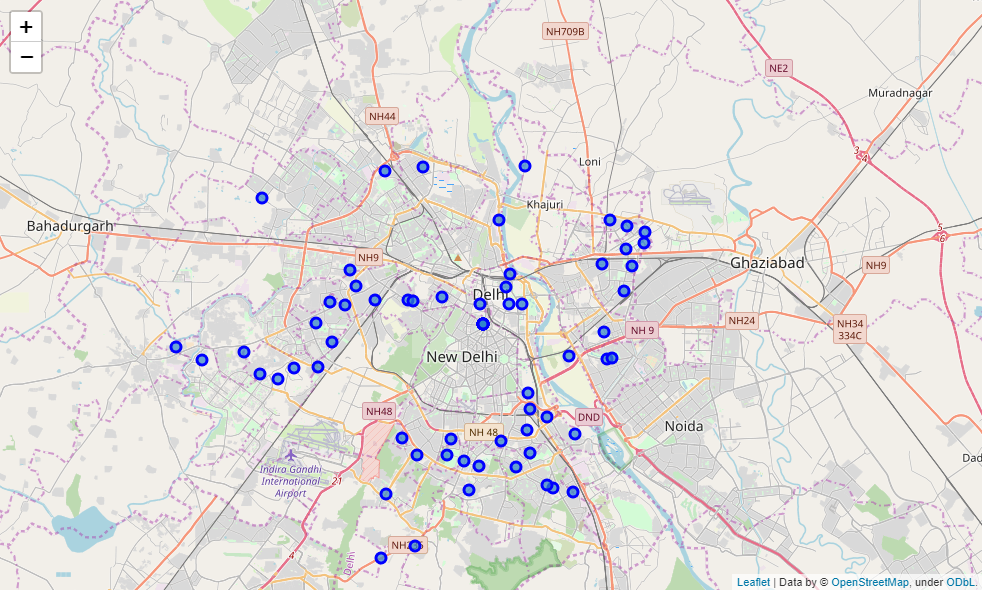

In [173]:
Image(filename = PATH + "Delhi and Neighbourhoods.png")

**Retrieving the FourSquare API Credentials**<br>
I have added the API ID and Key to the <i>environment variables</i> on Windows and I use the <i>os</i> library to import the credentials. This keeps it secure while sharing the notebook on github or with someone else.

In [29]:
CLIENT_ID = os.environ.get('FS_ID') 
CLIENT_SECRET = os.environ.get('FS_SECRET') 
VERSION = '20180604'

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' 

#### Defining the function to obtain top venues from each Neighbourhood

In [119]:
def getNearbyVenues(names, latitudes, longitudes, radius=3000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Running the function and creating a new dataframe called <i> delhi_venues </i>.

In [120]:
delhi_venues = getNearbyVenues(names=delhi_data['Neighbourhoods'],
                               latitudes=delhi_data['Latitude'],
                               longitudes=delhi_data['Longitude'])

CHANDNI CHOWK
JANAK PURI NORTH
JANAK PURI WEST
JANAK PURI SOUTH
KAKRAULA
DILSHAD GARDEN
NEW SEEMA PURI
NAND NAGRI
SUNDER NAGARI
ASHOK NAGAR
NIZAMUDDIN
BHOGAL
KASTURBA NAGAR
MALVIYA NAGAR
ANDREWSGANJ
VASANT VIHAR
MUNIRKA
NANAK PURA
VASANTKUNJ
DAKSHINPURI EXT.
SHAPUR JAT
GREATER KAILASH-I
EAST OF KAILASH
GOVIND PURI
KALKAJI
OKHLA
PAHAR GANJ
VIVEK VIHAR
DILSHAD COLONY
PUNJABI BAGH
KIRTI NAGAR
KASHMERE GATE
MAJNU KA TILA
JAMA MASJID
UTTAM NAGAR
DABRI
MAYUR VIHAR PHASE-I
ROHINI
PASCHIM VIHAR SOUTH
ROHINI EAST
ROHINI CENTRAL
ROHINI SOUTH
I.P EXTENTION
ANAND VIHAR
MAYUR VIHAR PHASE II
MAHAVIR ENCLAVE
EAST PATEL NAGAR
WEST PATEL NAGAR
KAROL BAGH
JAHANGIRPURI-I
RAJOURI GARDEN
HARI NAGAR
MADHU VIHAR
ROHINI NORTH
MOTI NAGAR
LAJPAT NAGAR
SAFDARJANG ENCLAVE
HAUZ KHAS
TAGORE GARDEN
PANDAV NAGAR
ZAKIR NAGAR
MAHAVIR NAGAR
DARYAGANJ


Let's have a look at the delhi_venues dataframe and its shape

In [121]:
print(delhi_venues.shape)
delhi_venues.head(7)

(3874, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,CHANDNI CHOWK,28.65624,77.23233,Haveli Dharampura,28.653247,77.232309,Hotel
1,CHANDNI CHOWK,28.65624,77.23233,Karim's | करीम | کریم (Karim's),28.649498,77.233691,Indian Restaurant
2,CHANDNI CHOWK,28.65624,77.23233,Red Fort | Lal Qila | लाल क़िला | لال قلعہ (Re...,28.655759,77.241955,Monument / Landmark
3,CHANDNI CHOWK,28.65624,77.23233,Jolly Creations Designer Boutique,28.662689,77.226300,Boutique
4,CHANDNI CHOWK,28.65624,77.23233,Jama Masjid |जामा मस्जिद | جامع مسجد (Jama Ma...,28.650136,77.233541,Mosque
5,CHANDNI CHOWK,28.65624,77.23233,Kake Di Hatti | काके दी हट्टी,28.658050,77.223377,Indian Restaurant
6,CHANDNI CHOWK,28.65624,77.23233,Red Fort Archaeological Museum | लाल किला पुरा...,28.655964,77.237655,Museum


In [122]:
delhi_venues.to_csv(r'DelhiVenues.csv',index=None, header=True)

## Exploratory data analysis

In [59]:
import numpy as np
from scipy.spatial.distance import cdist

#importing libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means for clustering stage
from sklearn.cluster import KMeans


In [35]:
#delhi_data = pd.read_csv('DelhiHoodData.csv')
#delhi_venues = pd.read_csv('DelhiVenues.csv')

In [123]:
summary = delhi_venues.groupby('Neighborhood').count().reset_index()
summary.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], axis=1, inplace=True)
summary.rename(columns={'Neighborhood':'Neighbourhoods','Venue':'Count'}, inplace=True)
summary = summary.sort_values('Count').reset_index(drop=True)
summary.head()

,Neighbourhoods,Count
0,SUNDER NAGARI,7
1,NAND NAGRI,8
2,ROHINI CENTRAL,10
3,NEW SEEMA PURI,10
4,JANAK PURI SOUTH,12


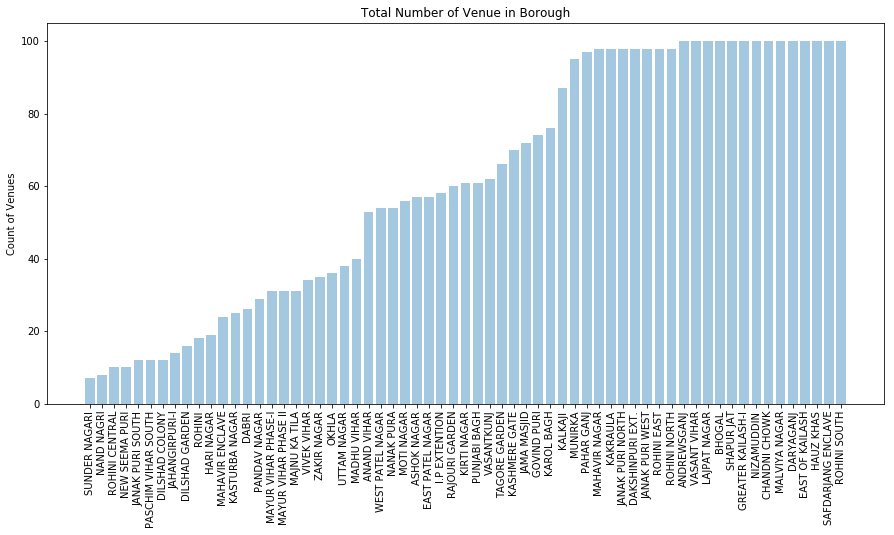

In [125]:
objects = summary.Neighbourhoods
y_pos = np.arange(len(objects))
performance = summary.Count

plt.figure(figsize=(15,7))
plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Count of Venues')
plt.title('Total Number of Venue in Borough')
plt.xticks(rotation=90)

plt.show()

We can see that Janak Puri North, Dakshinpuri Extension, Rohini East, Kakraula, Janak Puri West, Rohini North and Mahavir Nagar have reached the 100 limit of venue, while there are many Neighbourhoods for which the venue count failed to reach even 20. 

In [126]:
print('There are {} uniques categories.'.format(len(delhi_venues['Venue Category'].unique())))

There are 167 uniques categories.


In [127]:
# one hot encoding
delhi_onehot = pd.get_dummies(delhi_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
delhi_onehot['Neighbourhoods'] = delhi_venues['Neighborhood'] 

# move neighborhood column to the first column
list_column = delhi_onehot.columns.tolist()
number_column = int(list_column.index('Neighbourhoods'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
delhi_onehot = delhi_onehot[list_column]

delhi_onehot.head()

,Neighbourhoods,ATM,Accessories Store,Airport Food Court,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,...,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Udupi Restaurant,University,Vegetarian / Vegan Restaurant,Yoga Studio
0,CHANDNI CHOWK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHANDNI CHOWK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHANDNI CHOWK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHANDNI CHOWK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHANDNI CHOWK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
delhi_grouped = delhi_onehot.groupby('Neighbourhoods').mean().reset_index()
delhi_grouped.head()

,Neighbourhoods,ATM,Accessories Store,Airport Food Court,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,...,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Udupi Restaurant,University,Vegetarian / Vegan Restaurant,Yoga Studio
0,ANAND VIHAR,0.0,0.0,0.0,0.000000,0.018868,0.0,0.0,0.00,0.018868,...,0.0,0.0,0.018868,0.0,0.018868,0.0,0.0,0.0,0.0,0.018868
1,ANDREWSGANJ,0.0,0.0,0.0,0.000000,0.010000,0.0,0.0,0.01,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,ASHOK NAGAR,0.0,0.0,0.0,0.017544,0.017544,0.0,0.0,0.00,0.000000,...,0.0,0.0,0.000000,0.0,0.017544,0.0,0.0,0.0,0.0,0.000000
3,BHOGAL,0.0,0.0,0.0,0.000000,0.010000,0.0,0.0,0.01,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,CHANDNI CHOWK,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.01,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


In [129]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [130]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
wards_venues_sorted = pd.DataFrame(columns=columns)
wards_venues_sorted['Neighbourhoods'] = delhi_grouped['Neighbourhoods']

for ind in np.arange(delhi_grouped.shape[0]):
    wards_venues_sorted.iloc[ind, 1:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)

wards_venues_sorted.head()

,Neighbourhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANAND VIHAR,Pizza Place,Café,Hotel,Indian Restaurant,Park,Movie Theater,Fast Food Restaurant,Shopping Mall,Multiplex,Shop & Service
1,ANDREWSGANJ,Indian Restaurant,Market,Café,Italian Restaurant,Chinese Restaurant,Bar,Restaurant,Coffee Shop,Donut Shop,Hotel
2,ASHOK NAGAR,Indian Restaurant,Café,Fast Food Restaurant,Pizza Place,Coffee Shop,BBQ Joint,Donut Shop,Hotel,Clothing Store,Shopping Mall
3,BHOGAL,Indian Restaurant,Café,Italian Restaurant,Hotel,Restaurant,Sandwich Place,Market,BBQ Joint,Chinese Restaurant,Donut Shop
4,CHANDNI CHOWK,Indian Restaurant,Hotel,Fast Food Restaurant,Snack Place,Café,Dessert Shop,Bar,Bakery,Lounge,Market


In [131]:
delhi_grouped_clustering = delhi_grouped.drop('Neighbourhoods', axis=1)
delhi_grouped_clustering.head()

,ATM,Accessories Store,Airport Food Court,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Udupi Restaurant,University,Vegetarian / Vegan Restaurant,Yoga Studio
0,0.0,0.0,0.0,0.000000,0.018868,0.0,0.0,0.00,0.018868,0.00,...,0.0,0.0,0.018868,0.0,0.018868,0.0,0.0,0.0,0.0,0.018868
1,0.0,0.0,0.0,0.000000,0.010000,0.0,0.0,0.01,0.000000,0.01,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.017544,0.017544,0.0,0.0,0.00,0.000000,0.00,...,0.0,0.0,0.000000,0.0,0.017544,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.000000,0.010000,0.0,0.0,0.01,0.000000,0.00,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.01,0.000000,0.00,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


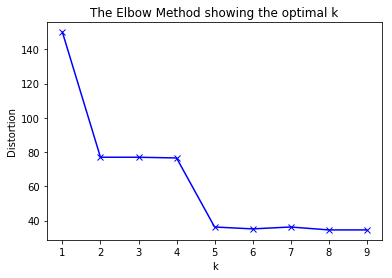

In [132]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(init="k-means++", n_clusters=k, n_init=12).fit(delhi_grouped_clustering)
    distortions.append(sum(np.min(cdist(delhi_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1))/delhi_grouped_clustering.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [133]:
k = 5
kmeans = KMeans(init="k-means++", n_clusters=k, n_init=12).fit(delhi_grouped_clustering)
kmeans.labels_

array([2, 1, 2, 1, 4, 2, 4, 4, 0, 0, 1, 2, 1, 1, 2, 1, 2, 2, 4, 4, 1, 4,
       4, 1, 4, 4, 0, 2, 1, 2, 2, 4, 2, 1, 2, 2, 2, 1, 2, 0, 0, 1, 2, 4,
       2, 2, 2, 2, 2, 3, 4, 4, 1, 1, 1, 0, 2, 2, 1, 1, 2, 2, 2])

In [134]:
delhi_merged = delhi_data.sort_values('Neighbourhoods')

delhi_merged['Cluster Labels'] = kmeans.labels_

delhi_merged = delhi_merged.join(wards_venues_sorted.set_index('Neighbourhoods'), on='Neighbourhoods')

delhi_merged.head()

,Ward Number,Neighbourhoods,Latitude,Longitude,AvgPricePerSqMtr,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,225,ANAND VIHAR,28.653561,77.313728,128000,54339,2,Pizza Place,Café,Hotel,Indian Restaurant,Park,Movie Theater,Fast Food Restaurant,Shopping Mall,Multiplex,Shop & Service
14,159,ANDREWSGANJ,28.563440,77.228973,246000,46561,1,Indian Restaurant,Market,Café,Italian Restaurant,Chinese Restaurant,Bar,Restaurant,Coffee Shop,Donut Shop,Hotel
9,246,ASHOK NAGAR,28.634520,77.101768,70380,50424,2,Indian Restaurant,Café,Fast Food Restaurant,Pizza Place,Coffee Shop,BBQ Joint,Donut Shop,Hotel,Clothing Store,Shopping Mall
11,156,BHOGAL,28.582760,77.248779,774000,46724,1,Indian Restaurant,Café,Italian Restaurant,Hotel,Restaurant,Sandwich Place,Market,BBQ Joint,Chinese Restaurant,Donut Shop
0,80,CHANDNI CHOWK,28.656240,77.232330,70080,1978,4,Indian Restaurant,Hotel,Fast Food Restaurant,Snack Place,Café,Dessert Shop,Bar,Bakery,Lounge,Market


In [135]:
count_venue = delhi_merged[['Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue', '6th Most Common Venue', '7th Most Common Venue', '8th Most Common Venue', '9th Most Common Venue', '10th Most Common Venue']]
count_venue = count_venue.groupby(['Cluster Labels', '1st Most Common Venue']).size().reset_index(name='Counts')

count_venue

,Cluster Labels,1st Most Common Venue,Counts
0,0,Juice Bar,1
1,0,Park,4
2,0,Pizza Place,1
3,1,Café,4
4,1,Coffee Shop,1
5,1,Indian Restaurant,12
6,2,Café,1
7,2,Coffee Shop,1
8,2,Fast Food Restaurant,7
9,2,Hotel,1


In [136]:
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,ATM,Café,Coffee Shop,Fast Food Restaurant,Hotel,Indian Restaurant,Juice Bar,Park,Pizza Place
0,0,0,0,0,0,0,1,4,1
1,0,4,1,0,0,12,0,0,0
2,0,1,1,7,1,7,0,1,8
3,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,12,0,0,0


Text(0, 0.5, 'Clusters')

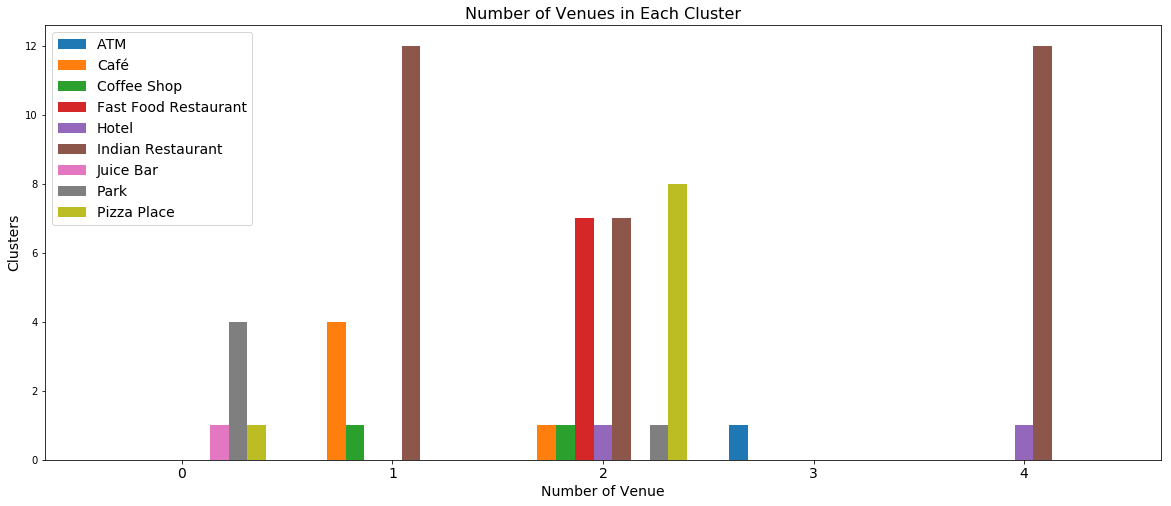

In [137]:
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Number of Venue', fontsize=14)
plt.ylabel('Clusters', fontsize=14)

After examining the above graph we can label each cluster as follows:
* Cluster 0: 'Parks and Recreation'
* Cluster 1: 'Cafe and Restaurants'
* Cluster 2: 'Multiple Social Venues'
* Cluster 3: 'ATMs'
* Cluster 4: 'Accomodation and Indian Restaurants'

In [138]:
Cluster_labels = {'Clusters': [0,1,2,3,4], 'Labels': ['Parks and Recreation', 'Cafe and Restaurants', 'Multiple Social Venues', 'ATMs', 'Accomodation and Indian Restaurants']}
Cluster_labels = pd.DataFrame(data=Cluster_labels)
Cluster_labels

,Clusters,Labels
0,0,Parks and Recreation
1,1,Cafe and Restaurants
2,2,Multiple Social Venues
3,3,ATMs
4,4,Accomodation and Indian Restaurants


In [139]:
data_process = delhi_merged[['Neighbourhoods', 'AvgPricePerSqMtr', 'Cluster Labels']]
data_process.head()

,Neighbourhoods,AvgPricePerSqMtr,Cluster Labels
43,ANAND VIHAR,128000,2
14,ANDREWSGANJ,246000,1
9,ASHOK NAGAR,70380,2
11,BHOGAL,774000,1
0,CHANDNI CHOWK,70080,4


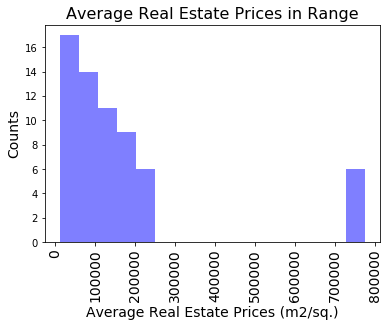

In [159]:
n, bins, patches = plt.hist(data_process['AvgPricePerSqMtr'], 16, facecolor='blue', alpha=0.5)
plt.title("Average Real Estate Prices in Range",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=90)
plt.xlabel('Average Real Estate Prices (m2/sq.)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

As it seems in above histogram, we can define the ranges as below:
* <40,000 : "Low Level"
* 40,000-80,000 : "Mid-1 Level"
* 120,000-160,000 : "Mid-2 Level"
* 240,000-280,000 : "High-1 Level"
* \>320,000 : "High-2 Level"

In [158]:
data_process['AvgPricePerSqMtr'].unique()

array([128000, 246000,  70380, 774000,  70080,  46200,  56640, 160000,
        33300,  11997], dtype=int64)

In [160]:
level = []
for i in range(0,len(data_process)):
    if (data_process['AvgPricePerSqMtr'][i] < 40000):
        level.append("Low Level HSP")
    elif (data_process['AvgPricePerSqMtr'][i] >= 40000 and data_process['AvgPricePerSqMtr'][i] < 80000):
        level.append("Mid-1 Level HSP")
    elif (data_process['AvgPricePerSqMtr'][i] >= 120000 and data_process['AvgPricePerSqMtr'][i] < 160000):
        level.append("Mid-2 Level HSP")
    elif (data_process['AvgPricePerSqMtr'][i] >= 240000 and data_process['AvgPricePerSqMtr'][i] < 280000):
        level.append("High-1 Level HSP")
    else:
        level.append("High-2 Level HSP")   

data_process['Level_labels'] = level
data_process.head()

C:\Users\rahul\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Neighbourhoods,AvgPricePerSqMtr,Cluster Labels,Level_labels
43,ANAND VIHAR,128000,2,Mid-1 Level HSP
14,ANDREWSGANJ,246000,1,Mid-2 Level HSP
9,ASHOK NAGAR,70380,2,Mid-2 Level HSP
11,BHOGAL,774000,1,Mid-2 Level HSP
0,CHANDNI CHOWK,70080,4,Low Level HSP


In [163]:
top3 = delhi_venues.groupby(['Neighborhood','Venue Category']).size().reset_index(name='Counts')
top3 = top3.sort_values(['Neighborhood','Counts'],ascending=False).groupby('Neighborhood').head(3).reset_index(drop=True)
top3.rename(columns={'Neighborhood':'Neighbourhoods'}, inplace=True)
top3['Highlights'] = top3['Counts'].map(str) + " " + top3['Venue Category']
top3 = top3.groupby(['Neighbourhoods'])['Highlights'].apply(", ".join).reset_index()

top3.head()

,Neighbourhoods,Highlights
0,ANAND VIHAR,"7 Pizza Place, 4 Café, 4 Hotel"
1,ANDREWSGANJ,"15 Indian Restaurant, 8 Market, 7 Café"
2,ASHOK NAGAR,"6 Indian Restaurant, 5 Café, 5 Fast Food Resta..."
3,BHOGAL,"11 Café, 11 Indian Restaurant, 7 Italian Resta..."
4,CHANDNI CHOWK,"20 Indian Restaurant, 17 Hotel, 5 Fast Food Re..."


In [168]:
result = pd.merge(delhi_merged, 
                    top3[['Neighbourhoods', 'Highlights']],
                    on = 'Neighbourhoods',
                    how = 'left')
result= pd.merge(result, 
                    Cluster_labels[['Clusters', 'Labels']],
                    left_on = 'Cluster Labels',
                    right_on = 'Clusters',
                    how = 'left')
result = pd.merge(result, 
                    data_process[['Neighbourhoods', 'Level_labels']],
                    on = 'Neighbourhoods',
                    how = 'left')

result = result.drop(['Clusters'], axis=1)
result.head()

,Ward Number,Neighbourhoods,Latitude,Longitude,AvgPricePerSqMtr,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Highlights,Labels,Level_labels
0,225,ANAND VIHAR,28.653561,77.313728,128000,54339,2,Pizza Place,Café,Hotel,Indian Restaurant,Park,Movie Theater,Fast Food Restaurant,Shopping Mall,Multiplex,Shop & Service,"7 Pizza Place, 4 Café, 4 Hotel",Multiple Social Venues,Mid-1 Level HSP
1,159,ANDREWSGANJ,28.563440,77.228973,246000,46561,1,Indian Restaurant,Market,Café,Italian Restaurant,Chinese Restaurant,Bar,Restaurant,Coffee Shop,Donut Shop,Hotel,"15 Indian Restaurant, 8 Market, 7 Café",Cafe and Restaurants,Mid-2 Level HSP
2,246,ASHOK NAGAR,28.634520,77.101768,70380,50424,2,Indian Restaurant,Café,Fast Food Restaurant,Pizza Place,Coffee Shop,BBQ Joint,Donut Shop,Hotel,Clothing Store,Shopping Mall,"6 Indian Restaurant, 5 Café, 5 Fast Food Resta...",Multiple Social Venues,Mid-2 Level HSP
3,156,BHOGAL,28.582760,77.248779,774000,46724,1,Indian Restaurant,Café,Italian Restaurant,Hotel,Restaurant,Sandwich Place,Market,BBQ Joint,Chinese Restaurant,Donut Shop,"11 Café, 11 Indian Restaurant, 7 Italian Resta...",Cafe and Restaurants,Mid-2 Level HSP
4,80,CHANDNI CHOWK,28.656240,77.232330,70080,1978,4,Indian Restaurant,Hotel,Fast Food Restaurant,Snack Place,Café,Dessert Shop,Bar,Bakery,Lounge,Market,"20 Indian Restaurant, 17 Hotel, 5 Fast Food Re...",Accomodation and Indian Restaurants,Low Level HSP


In [185]:
latitude = 28.6517178
longitude = 77.2219388
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, Highlights, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['Neighbourhoods'], result['Labels'], result['Highlights'], result['Cluster Labels'], result['Level_labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(Highlights), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color= rainbow[cluster_number-1],
        popup=label,
        fill_color = rainbow[cluster_number-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

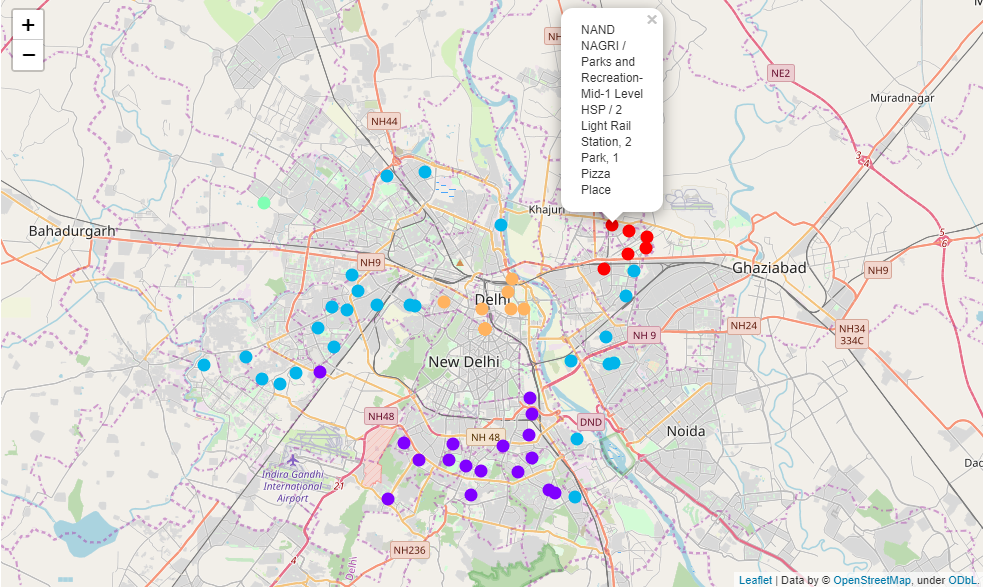

In [184]:
Image(filename = PATH + "Delhi Clusters.png")

In [208]:
with open('Delhi_Wards - Copy.geojson') as json_data:
    delhi_geojson = json.load(json_data)

delhi_map = folium.Map(location=[latitude, longitude], zoom_start=10)

In [209]:
delhi_map.choropleth(
    geo_data=delhi_geojson,
    data=delhi_data,
    columns=['Neighbourhoods','AvgPricePerSqMtr'],
    key_on='feature.properties.Ward_Name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='House Sales Price in Delhi',
    highlight=True
)

markers_colors = []
for lat, lon, poi, cluster, Highlights, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['Neighbourhoods'], result['Labels'], result['Highlights'], result['Cluster Labels'], result['Level_labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(Highlights), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color= rainbow[cluster_number-1],
        fill=True,
        fill_color= rainbow[cluster_number-1],
        fill_opacity=1).add_to(delhi_map)
   
delhi_map